In [115]:
# Imports
import pandas as pd
import numpy as np
import os

In [116]:
# Load data

team_id = '20' #put your team id here
split = 'test_1' # replace by 'test_2' for FINAL submission

df = pd.read_csv('dataset/tweets_train.csv')
df_test = pd.read_csv(f'dataset/tweets_{split}.csv')

In [117]:
df['words_str'] = df['words'].apply(lambda words: ' '.join(eval(words)))
df_test['words_str'] = df_test['words'].apply(lambda words: ' '.join(eval(words)))

In [118]:
from sentence_transformers import SentenceTransformer

# Specify the model name
# I downloaded in models directory three models: 
# all-MiniLM-L6-v2(Fastest but smalles), stsb-roberta-base-v2(middle), and stsb-mpnet-base-v2(Slowest, but best performance)

name = 'stsb-mpnet-base-v2'


# Download and save the model if not available
#model = SentenceTransformer(name)

#model.save('models/' + name)

# Load the model
model_enc = SentenceTransformer('models/' + name).to('cuda')

In [119]:
# List of sentences to get embeddings for
sentences = list(df.words_str.values)

# Get the sentence embeddings
sentence_embeddings = model_enc.encode(sentences)

# Classification

In [120]:
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import sklearn.metrics as skm
from sklearn.metrics import f1_score


In [121]:
X = sentence_embeddings
y_text = df.sentiment.values
le = preprocessing.LabelEncoder()
le.fit(y_text)
print(f'Original classes {le.classes_}')
print(f'Corresponding numeric classes {le.transform(le.classes_)}')
y =le.transform(y_text)
print(f"X: {X.shape}")
print(f"y: {y.shape} {np.unique(y)}")
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

datasets = [
    [X_train, y_train],
    [X_val, y_val]
]

Original classes ['negative' 'neutral' 'positive']
Corresponding numeric classes [0 1 2]
X: (8000, 768)
y: (8000,) [0 1 2]


In [122]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ClassificationNN(nn.Module):
    def __init__(self, input_dim, num_classes=3, dropout_rate=0.5):
        super(ClassificationNN, self).__init__()
        
        # First set of layers
        self.fc1 = nn.Linear(input_dim, 256)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(dropout_rate)
        
        # Second set of layers
        self.fc3 = nn.Linear(128, 128)
        self.dropout3 = nn.Dropout(dropout_rate)
        self.fc4 = nn.Linear(128, 64)
        self.dropout4 = nn.Dropout(dropout_rate)
        
        # Output layer
        self.fc5 = nn.Linear(64, num_classes)

    def forward(self, x):
        # First set of layers
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        
        # Second set of layers
        x = F.relu(self.fc3(x))
        x = self.dropout3(x)
        x = F.relu(self.fc4(x))
        x = self.dropout4(x)
        
        # Output
        x = self.fc5(x)
        return x


In [123]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [124]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.long).to(device)


In [125]:
# Count the number of occurrences of each class
class_counts = df['sentiment'].value_counts()

# Calculate the proportions of each class
class_proportions = class_counts / len(df)

# Calculate weights as the inverse of class proportions
weights = 1. / class_proportions

# Normalize the weights so they sum to 1
weights = weights / weights.sum()

# Print the weights
print(weights)


sentiment
neutral     0.069689
positive    0.165465
negative    0.764846
Name: count, dtype: float64


In [126]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Hyperparameters
learning_rate = 0.001
epochs = 100
batch_size = 32

# Initialize the model and move to the device
model_clf = ClassificationNN(X_train.shape[1]).to(device)

# weights = torch.tensor([0.764846, 0.069689, 0.165465], dtype=torch.float32).to(device)
# Loss and optimizer
criterion = nn.CrossEntropyLoss()  # This criterion combines nn.LogSoftmax() and nn.NLLLoss
weight_decay_value = 1e-5  # This is a hyperparameter and can be adjusted
optimizer = torch.optim.AdamW(model_clf.parameters(), lr=learning_rate, weight_decay=weight_decay_value)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=10, verbose=True)

# Helper function to compute f1_score
def compute_f1_score(y_true, y_pred):
    y_true = y_true.cpu().numpy()
    y_pred = torch.argmax(y_pred, dim=1).cpu().numpy()
    return f1_score(y_true, y_pred, average='weighted')

# Training loop
training_losses = []
validation_losses = []
training_f1 = []
validation_f1 = []

best_f1 = float('-inf')  # start with a very low value
best_epoch = -1  # an invalid epoch number to start with

for epoch in range(epochs):
    # Set model to training mode and ensure it's on the right device
    model_clf.train().to(device)
    
    # Forward pass on training data
    train_outputs = model_clf(X_train_tensor)
    train_loss = criterion(train_outputs, y_train_tensor)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    
    # Set model to evaluation mode
    model_clf.eval()
    with torch.no_grad():
        # Forward pass on validation data
        val_outputs = model_clf(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
        scheduler.step(val_loss)
    
    # Store the losses for plotting
    training_losses.append(train_loss.item())
    validation_losses.append(val_loss.item())
    
    # Calculate and store the F1 score for plotting
    train_f1 = compute_f1_score(y_train_tensor, train_outputs)
    val_f1 = compute_f1_score(y_val_tensor, val_outputs)
    training_f1.append(train_f1)
    validation_f1.append(val_f1)
    
    current_val_f1 = val_f1

    # Check if the current F1 score is better than the best F1 score
    if current_val_f1 > best_f1:
        best_f1 = current_val_f1
        best_epoch = epoch
    else:
        # Stop training after a certain number of epochs without improvement
        if epoch - best_epoch > 100:
            print(f"Stopping training after {epoch} epochs. Best F1 {best_f1:.4f} achieved at epoch {best_epoch}.")
            break
    
    # Print progress
    if epoch < 100 and epoch % 5 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {train_loss.item():.4f}, Validation Loss: {val_loss.item():.4f}, Training F1: {train_f1:.4f}, Validation F1: {val_f1:.4f}')
    elif 100 < epoch < 300 and epoch % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {train_loss.item():.4f}, Validation Loss: {val_loss.item():.4f}, Training F1: {train_f1:.4f}, Validation F1: {val_f1:.4f}')
    elif 300 < epoch < 1000 and epoch % 50 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {train_loss.item():.4f}, Validation Loss: {val_loss.item():.4f}, Training F1: {train_f1:.4f}, Validation F1: {val_f1:.4f}')
    elif epoch > 1000 and epoch % 1000 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {train_loss.item():.4f}, Validation Loss: {val_loss.item():.4f}, Training F1: {train_f1:.4f}, Validation F1: {val_f1:.4f}')

# If the loop completed without breaking, print the best F1 score achieved
if best_epoch != epoch:
    print(f"Training completed. Best F1 {best_f1:.4f} achieved at epoch {best_epoch}.")

Epoch [1/100], Training Loss: 1.1189, Validation Loss: 1.1094, Training F1: 0.0106, Validation F1: 0.0056
Epoch [6/100], Training Loss: 1.0674, Validation Loss: 1.0481, Training F1: 0.5095, Validation F1: 0.5521
Epoch [11/100], Training Loss: 0.9025, Validation Loss: 0.8181, Training F1: 0.5206, Validation F1: 0.5521
Epoch [16/100], Training Loss: 0.8321, Validation Loss: 0.7262, Training F1: 0.5228, Validation F1: 0.5521
Epoch [21/100], Training Loss: 0.7893, Validation Loss: 0.7468, Training F1: 0.5564, Validation F1: 0.5521
Epoch [26/100], Training Loss: 0.7462, Validation Loss: 0.6893, Training F1: 0.5603, Validation F1: 0.5521
Epoch [31/100], Training Loss: 0.7131, Validation Loss: 0.6443, Training F1: 0.5587, Validation F1: 0.5787
Epoch [36/100], Training Loss: 0.6577, Validation Loss: 0.6213, Training F1: 0.6584, Validation F1: 0.7290
Epoch [41/100], Training Loss: 0.6230, Validation Loss: 0.5907, Training F1: 0.6970, Validation F1: 0.7340
Epoch [46/100], Training Loss: 0.6024, 

Epoch [66/100], Training Loss: 0.5260, Validation Loss: 0.5539, Training F1: 0.7501, Validation F1: 0.7489
Epoch [71/100], Training Loss: 0.5052, Validation Loss: 0.5531, Training F1: 0.7584, Validation F1: 0.7503
Epoch [76/100], Training Loss: 0.4755, Validation Loss: 0.5533, Training F1: 0.7692, Validation F1: 0.7533
Epoch [81/100], Training Loss: 0.4569, Validation Loss: 0.5599, Training F1: 0.7748, Validation F1: 0.7536
Epoch 00082: reducing learning rate of group 0 to 1.0000e-04.
Epoch [86/100], Training Loss: 0.4397, Validation Loss: 0.5617, Training F1: 0.7806, Validation F1: 0.7551
Epoch [91/100], Training Loss: 0.4411, Validation Loss: 0.5618, Training F1: 0.7810, Validation F1: 0.7553
Epoch 00093: reducing learning rate of group 0 to 1.0000e-05.
Epoch [96/100], Training Loss: 0.4372, Validation Loss: 0.5616, Training F1: 0.7840, Validation F1: 0.7546
Training completed. Best F1 0.7556 achieved at epoch 76.


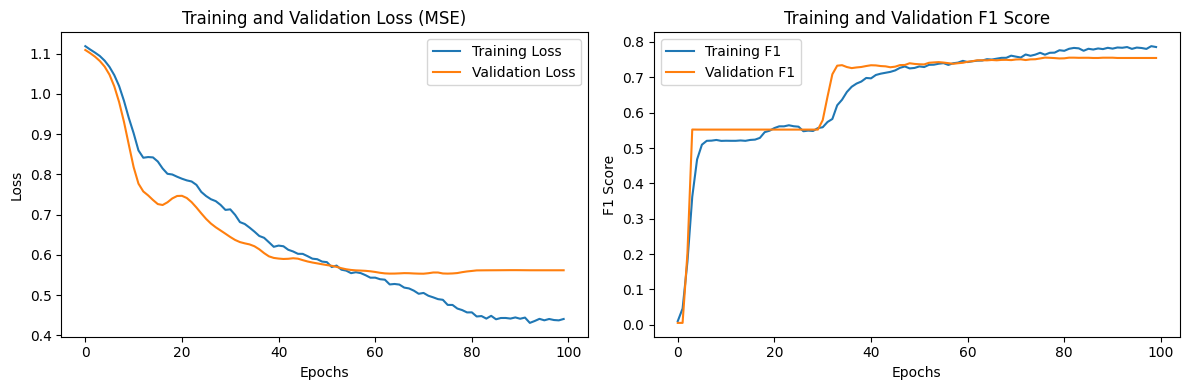

In [127]:
import matplotlib.pyplot as plt

# Plotting Training and Validation Loss (MSE)
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.title('Training and Validation Loss (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Training and Validation F1 Score
plt.subplot(1, 2, 2)
plt.plot(training_f1, label='Training F1')
plt.plot(validation_f1, label='Validation F1')
plt.title('Training and Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()


In [128]:
# Encode the test sentences
sentences = list(df_test.words_str.values)
X_test = model_enc.encode(sentences)

# Convert to a PyTorch tensor and move to the device
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)

# Get predictions with the neural network
model_clf.eval()  # Set the model to evaluation mode
with torch.no_grad():
    y_hat_tensor = model_clf(X_test_tensor)

# Get the class predictions
y_hat = torch.argmax(y_hat_tensor, dim=1)

# Convert the tensor to a numpy array
y_hat = y_hat.cpu().numpy()

# Convert the numerical labels back to original form
y_hat = le.inverse_transform(y_hat)

# Save the results with the specified format
directory = 'results'
np.save(os.path.join(directory, f'{team_id}__{split}__clf_pred.npy'), y_hat)


In [129]:
# Load 20__test_1__clf_pred.npy

np.load('results/20__test_1__clf_pred.npy', allow_pickle=True)

array(['neutral', 'neutral', 'neutral', 'positive', 'neutral', 'positive',
       'neutral', 'positive', 'neutral', 'neutral', 'positive', 'neutral',
       'positive', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral',
       'neutral', 'positive', 'neutral', 'positive', 'neutral', 'neutral',
       'positive', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral',
       'positive', 'positive', 'neutral', 'neutral', 'neutral', 'neutral',
       'neutral', 'neutral', 'positive', 'neutral', 'neutral', 'neutral',
       'neutral', 'neutral', 'positive', 'neutral', 'neutral', 'neutral',
       'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'neutral',
       'neutral', 'neutral', 'positive', 'neutral', 'neutral', 'neutral',
       'neutral', 'neutral', 'neutral', 'neutral', 'neutral', 'positive',
       'neutral', 'neutral', 'neutral', 'positive', 'positive', 'neutral',
       'neutral', 'neutral', 'neutral', 'positive', 'neutral', 'neutral',
       'positive', 'neutral', 'neu